# Sensitivity Analysis over Levers using SOBOL
- Perform sensitivityanalysis over 100 policies using SOBOL
- Analyze results to see variance in which levers causes the most variance in outcomes namely: 
  1)Annual Expected damage 2)Expected number of deaths

## 1)Importing the Packages

In [1]:
import time, itertools
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline

#from custom_funcs import *

from ema_workbench import (Model, IntegerParameter, RealParameter, CategoricalParameter, Constant,
                           ScalarOutcome, MultiprocessingEvaluator, Policy, Scenario)

from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.em_framework.optimization import EpsilonProgress, HyperVolume
from ema_workbench.util import ema_logging, save_results, load_results
from ema_workbench.analysis import prim, feature_scoring
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol
from problem_formulation import get_model_for_problem_formulation
ema_logging.log_to_stderr(ema_logging.INFO)

C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


<Logger EMA (DEBUG)>

In [2]:
problem_formulation_id = 2
dike_model,planning_steps = get_model_for_problem_formulation(problem_formulation_id)
reference_values = {'A.1_Bmax': 190,'A.2_Bmax': 190,'A.3_Bmax': 190,
                    'A.4_Bmax': 190,'A.5_Bmax': 190,'A.1_Brate': 1,
                    'A.2_Brate': 1,'A.3_Brate': 1,'A.4_Brate': 1,
                    'A.5_Brate': 1,'A.1_pfail': 0.5,'A.2_pfail': 0.5,
                    'A.3_pfail': 0.5,'A.4_pfail': 0.5,'A.5_pfail': 0.5,
                    'discount rate 0': 3.5,'discount rate 1': 3.5,
                    'A.0_ID flood wave shape': 4}

ref_scenario = Scenario('reference', **reference_values)
with MultiprocessingEvaluator(dike_model) as evaluator:
    experiments,outcomes = evaluator.perform_experiments(policies=100,scenarios=ref_scenario,
                                                         levers_sampling ='sobol')
results_df = pd.DataFrame.from_dict(outcomes) 
final_df = pd.concat([experiments,results_df],axis=1,sort=False)
final_df.to_csv('results_sobol.csv',index=False)

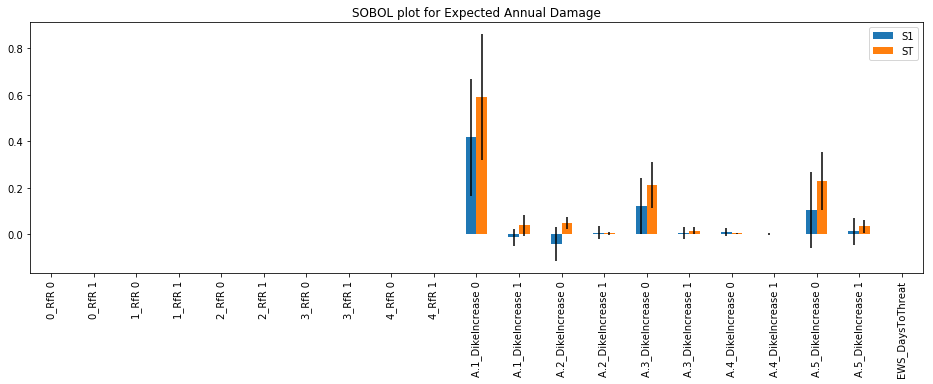

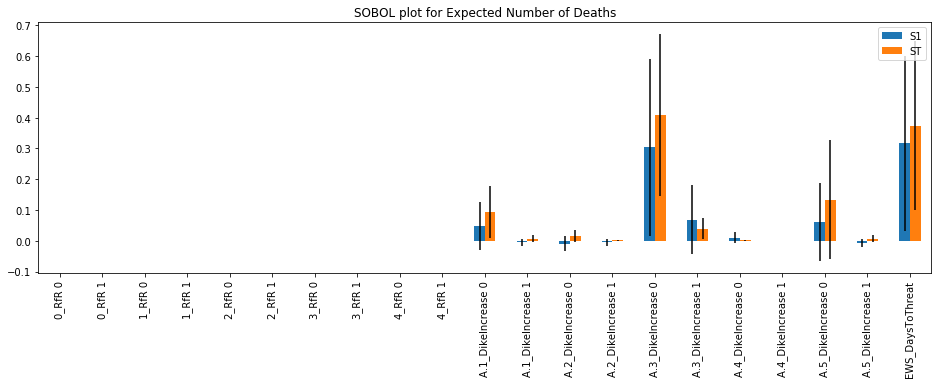

In [11]:
outcomes = ['Expected Annual Damage','Expected Number of Deaths']
for objective in outcomes:
    y = results_df[objective].values
    problem = get_SALib_problem(dike_model.levers)
    Si = sobol.analyze(problem,y,calc_second_order=True, 
                       print_to_console=False)
    scores_filtered = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
    Si_df = pd.DataFrame(scores_filtered, index=problem['names'])

    #sns.set_style('white')
    fig, ax = plt.subplots(1)

    indices = Si_df[['S1','ST']]
    err = Si_df[['S1_conf','ST_conf']]

    indices.plot.bar(yerr=err.values.T,ax=ax)
    fig.set_size_inches(16,6)
    fig.subplots_adjust(bottom=0.3)
    ax.set_title('SOBOL plot for ' + objective)
    plt.show()
    